In [3]:
from google.colab import files
uploaded = files.upload()


Saving training.csv to training (1).csv
Saving offers.csv to offers (1).csv


# Part 1: Pre-Processing

## Package and Data Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, StratifiedKFold, cross_val_predict, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV

import time


import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
data = pd.read_csv('training.csv')
print(data.shape)

(8050, 19)


## Data Cleaning

In [6]:
data[['length', 'width', 'depth']] = data['Measurements'].str.split('x', expand=True)

data[['length', 'width', 'depth']] = data[['length', 'width', 'depth']].apply(pd.to_numeric)

data['volume_mm3'] = data['length'] * data['width'] * data['depth']

print(data[['Measurements', 'volume_mm3']].head())
data = data.drop(columns=['Measurements'])


     Measurements  volume_mm3
0  4.65x4.62x3.03   65.093490
1  4.85x4.79x2.98   69.229870
2  4.66x4.63x2.97   64.080126
3  4.71x4.69x2.95   65.165205
4  4.71x4.68x2.96   65.246688


In [7]:
# Numeric Imputing
numeric_df = data.select_dtypes(include=['float', 'int64'])
non_numeric_df = data.select_dtypes(exclude='number')

# KNN to get the most accurate imputed values
knn_imputer = KNNImputer(n_neighbors=3)
imputed_numeric_array = knn_imputer.fit_transform(numeric_df)
imputed_numeric_df = pd.DataFrame(imputed_numeric_array, columns=numeric_df.columns)
imputed_df = pd.concat([imputed_numeric_df, non_numeric_df], axis=1)

# Fill missing values for categorical columns
imputed_df['Cert'] = imputed_df['Cert'].fillna('Missing')
imputed_df['Clarity'] = imputed_df['Clarity'].fillna(imputed_df['Clarity'].mode()[0])

imputed_df['Profit'] = imputed_df['Retail'] - imputed_df['Price']

# One hot encoding categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Set sparse_output=False
encoded_data = encoder.fit_transform(imputed_df[non_numeric_df.columns.tolist()])
print("Encoded data shape:", encoded_data.shape)

# Check if any columns have only one unique category and handle them
for col in non_numeric_df.columns:
    if imputed_df[col].nunique() == 1:
        print(f"Column '{col}' has only one unique value. Skipping one-hot encoding.")

# Convert encoded data into a DataFrame with the correct column names
encoded_column_names = encoder.get_feature_names_out(input_features=non_numeric_df.columns.tolist())
encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)


Encoded data shape: (8050, 88)


In [8]:
# Concatenate the encoded categorical columns with the numeric columns
final_df = pd.concat([imputed_numeric_df, encoded_df, imputed_df['Profit']], axis=1)

print(final_df.dtypes)
print(final_df.head())

id                    float64
Carats                float64
Depth                 float64
Table                 float64
Vendor                float64
                       ...   
Symmetry_Faint        float64
Symmetry_Fair         float64
Symmetry_Good         float64
Symmetry_Very good    float64
Profit                float64
Length: 102, dtype: object
    id  Carats  Depth  Table  Vendor  Price  Retail  LogPrice  LogRetail  \
0  1.0    0.41   65.4   58.0     1.0  430.0   850.0  6.063785   6.745236   
1  2.0    0.42   61.7   60.0     1.0  560.0   920.0  6.327937   6.824374   
2  3.0    0.40   64.0   57.0     1.0  560.0   575.0  6.327937   6.354370   
3  4.0    0.41   62.7   58.0     1.0  560.0   825.0  6.327937   6.715383   
4  5.0    0.40   63.0   58.0     1.0  580.0   890.0  6.363028   6.791221   

   length  ...  Shape_Round  Shape_Uncut  Symmetry_   Symmetry_Excellent  \
0    4.65  ...          0.0          0.0         0.0                 0.0   
1    4.85  ...          0.0       

## EDA and Data Visualizations

Using data visualizations to explore correlation between LogRetail and the other features. Additionally, exploring Profit relationships.

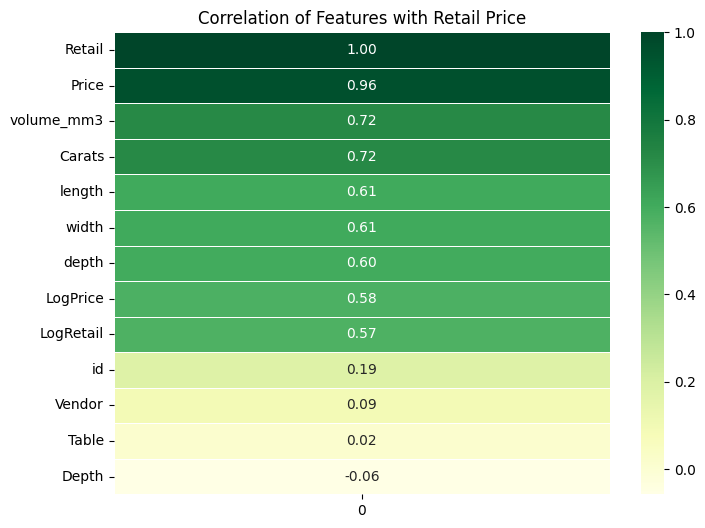

In [45]:
correlations = imputed_numeric_df.corrwith(imputed_numeric_df['Retail']).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(correlations.to_frame(), annot=True, cmap='YlGn', cbar=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation of Features with Retail Price')
plt.show()

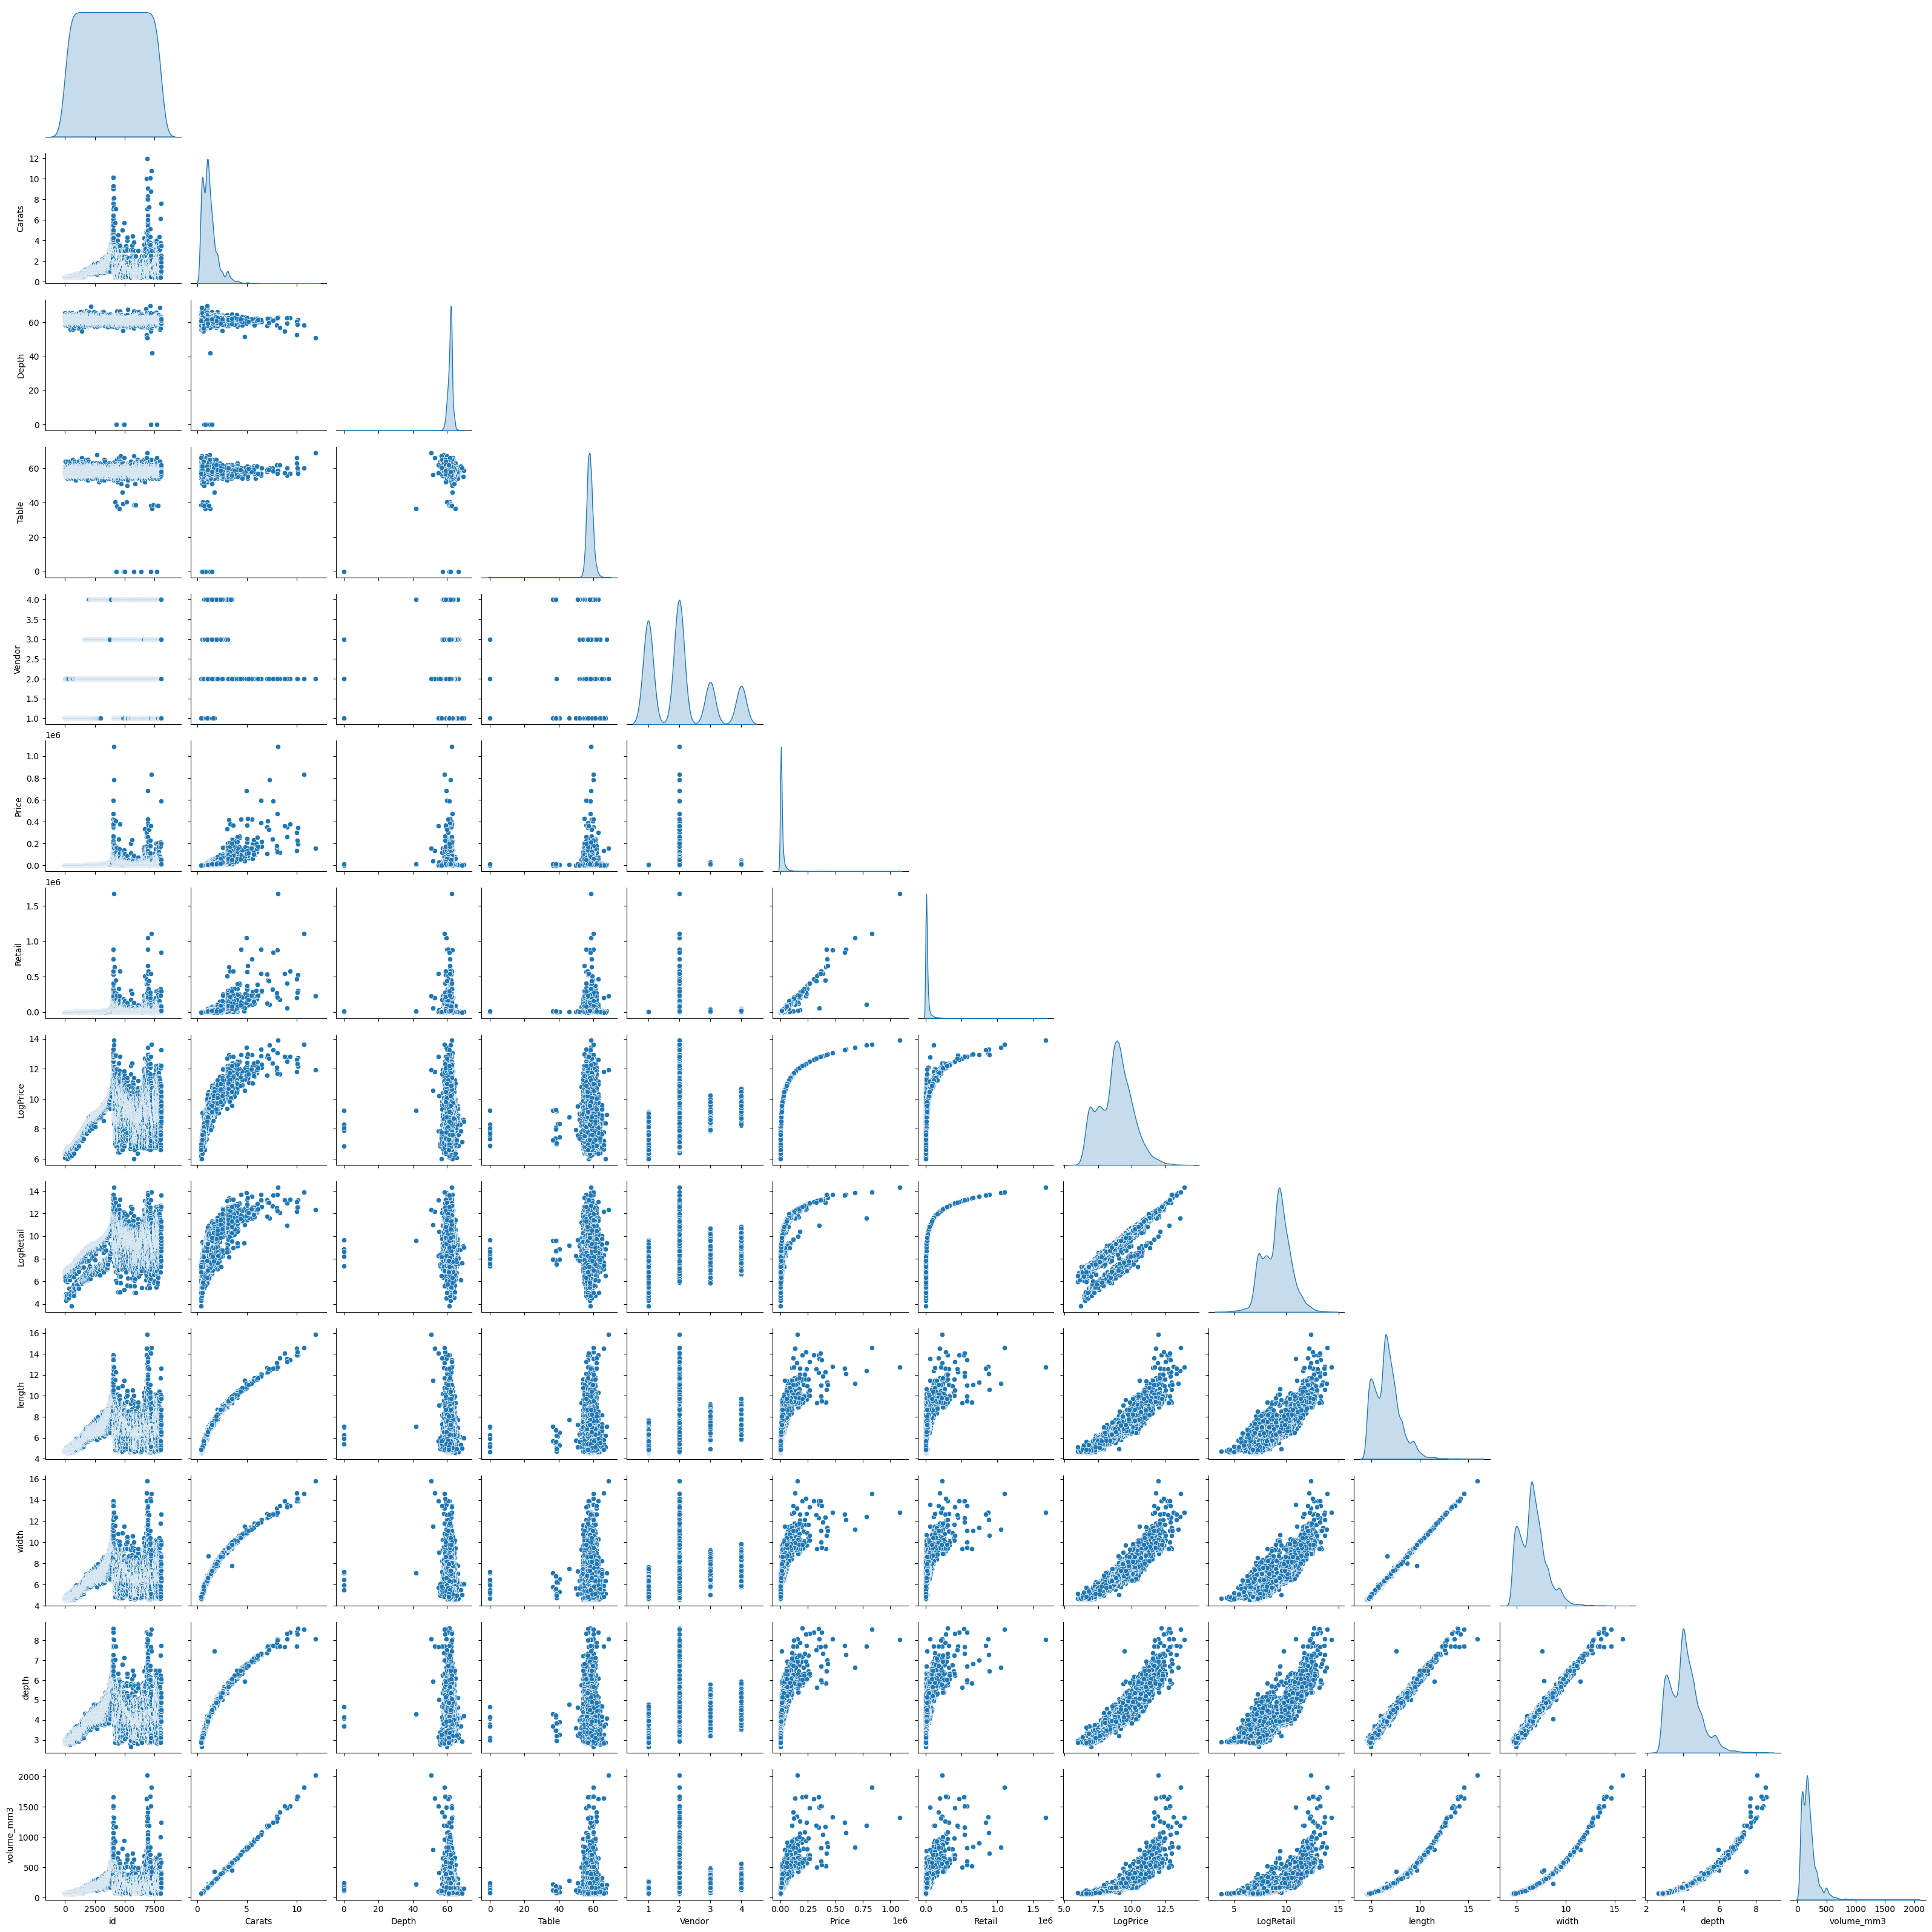

In [10]:
sns.pairplot(imputed_numeric_df, diag_kind="kde", corner=True, height=2.5, palette="coolwarm")


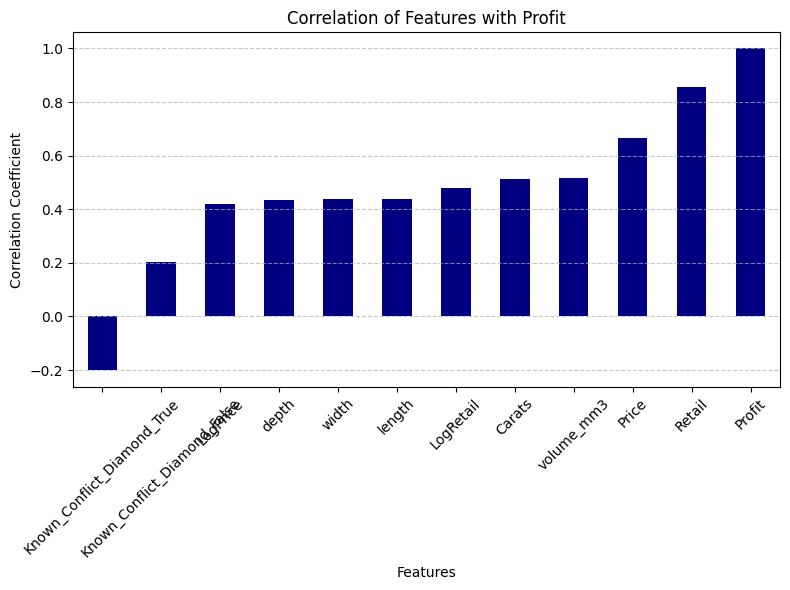

In [11]:
correlations = final_df.corrwith(final_df['Profit'])

filtered_correlations = correlations[abs(correlations) >= 0.15]

plt.figure(figsize=(8, 6))
filtered_correlations.sort_values().plot(kind='bar', color='navy')
plt.title('Correlation of Features with Profit')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


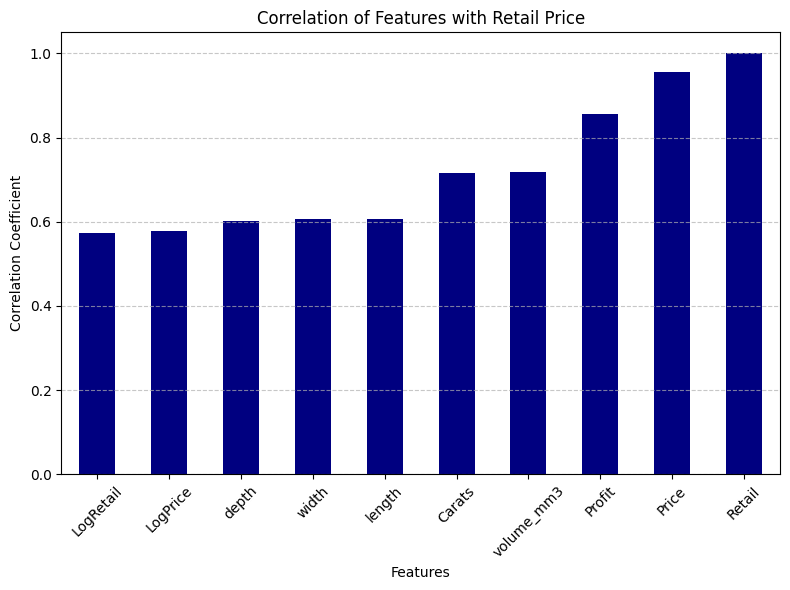

In [12]:
correlations = final_df.corrwith(final_df['Retail'])

filtered_correlations = correlations[abs(correlations) >= 0.25]

plt.figure(figsize=(8, 6))
filtered_correlations.sort_values().plot(kind='bar', color='navy')
plt.title('Correlation of Features with Retail Price')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [13]:
# Avg Profits

conflict_avg_profit = final_df[final_df['Known_Conflict_Diamond_True'] == 1]['Profit'].mean()
print(f"Average Profit for Known Conflict Diamonds: {conflict_avg_profit}")
no_conflict_avg_profit = final_df[final_df['Known_Conflict_Diamond_False'] == 1]['Profit'].mean()
print(f"Average Profit for No Known Conflict Diamonds: {no_conflict_avg_profit}")


Average Profit for Known Conflict Diamonds: -14086.213592233009
Average Profit for No Known Conflict Diamonds: 7232.0733755328765


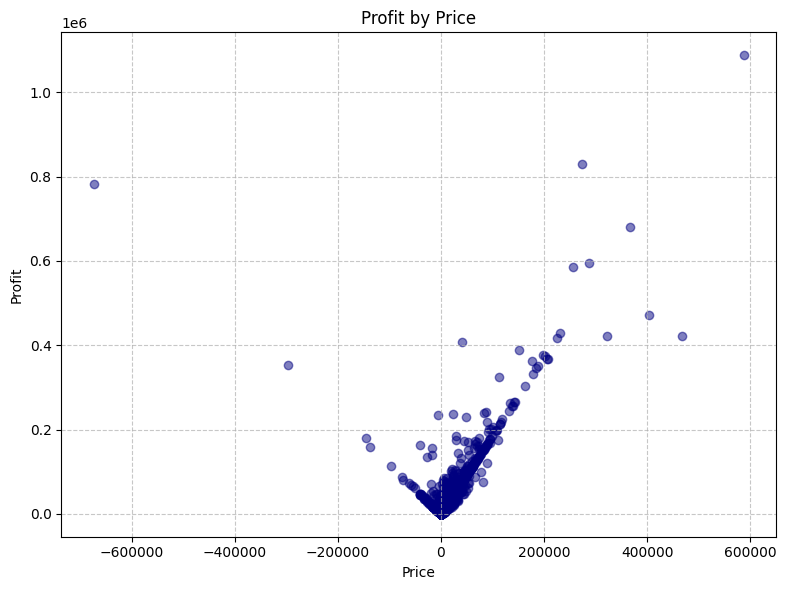

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(final_df['Profit'], final_df['Price'], color='navy', alpha=0.5)
plt.title('Profit by Price')
plt.xlabel('Price')
plt.ylabel('Profit')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

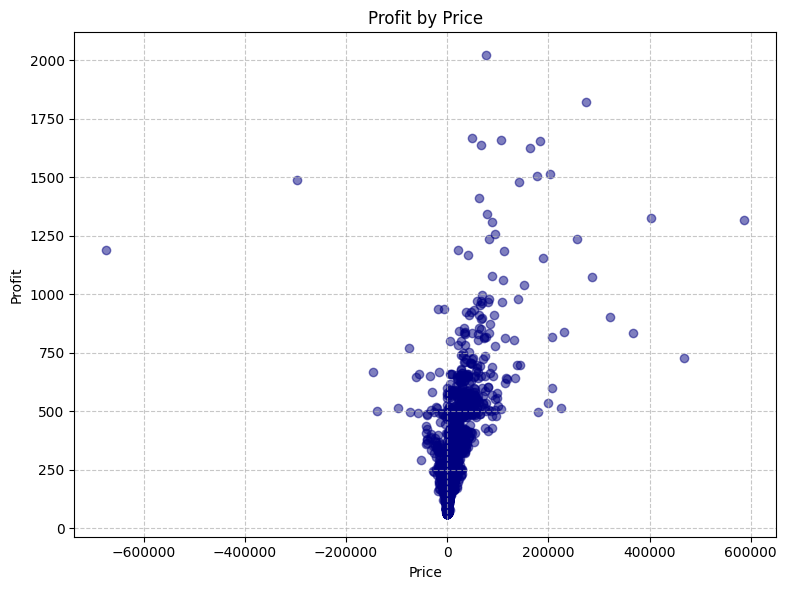

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(final_df['Profit'], final_df['volume_mm3'], color='navy', alpha=0.5)
plt.title('Profit by Volume')
plt.xlabel('Price')
plt.ylabel('Profit')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

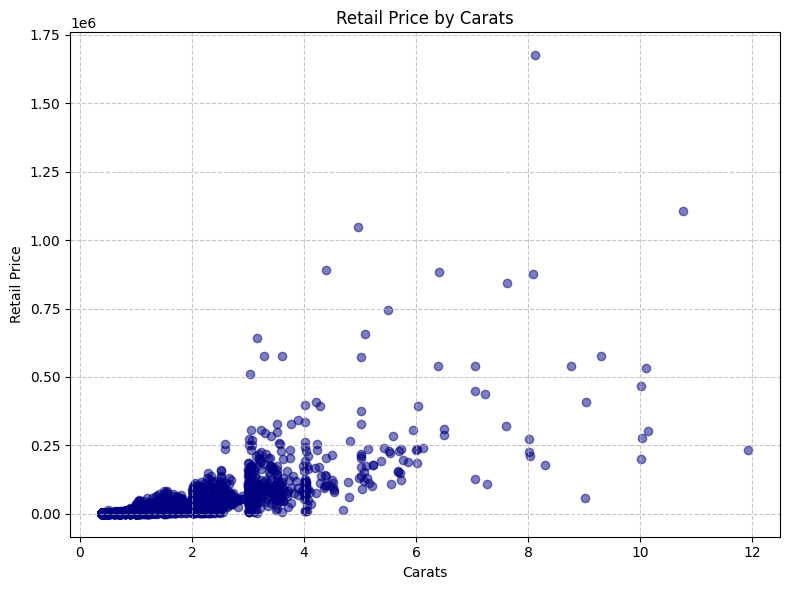

In [49]:
plt.figure(figsize=(8, 6))
plt.scatter(final_df['Carats'], final_df['Retail'], color='navy', alpha=0.5)
plt.title('Retail Price by Carats')
plt.xlabel('Carats')
plt.ylabel('Retail Price')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [98]:
# Check data types of the relevant columns
print(data[['Carats', 'Color', 'Clarity', 'Cut']].dtypes)

Carats     float64
Color       object
Clarity     object
Cut         object
dtype: object


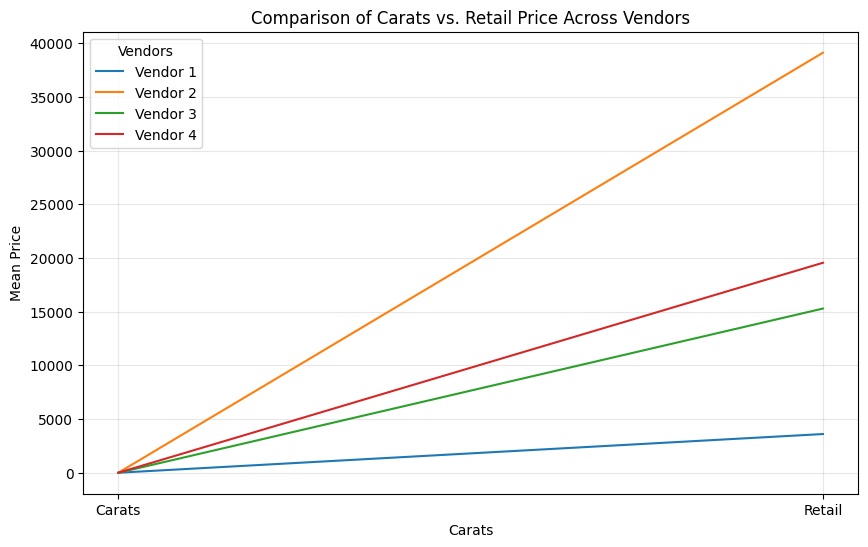

In [110]:
vendor_price_means = data.groupby('Vendor')[['Carats', 'Retail']].mean()

plt.figure(figsize=(10, 6))
for vendor in vendor_price_means.index:
    plt.plot(['Carats', 'Retail'], vendor_price_means.loc[vendor], label=f'Vendor {vendor}')

plt.title('Comparison of Carats vs. Retail Price Across Vendors')
plt.xlabel('Carats')
plt.ylabel('Mean Price')
plt.legend(title='Vendors')
plt.grid(alpha=0.3)
plt.show()


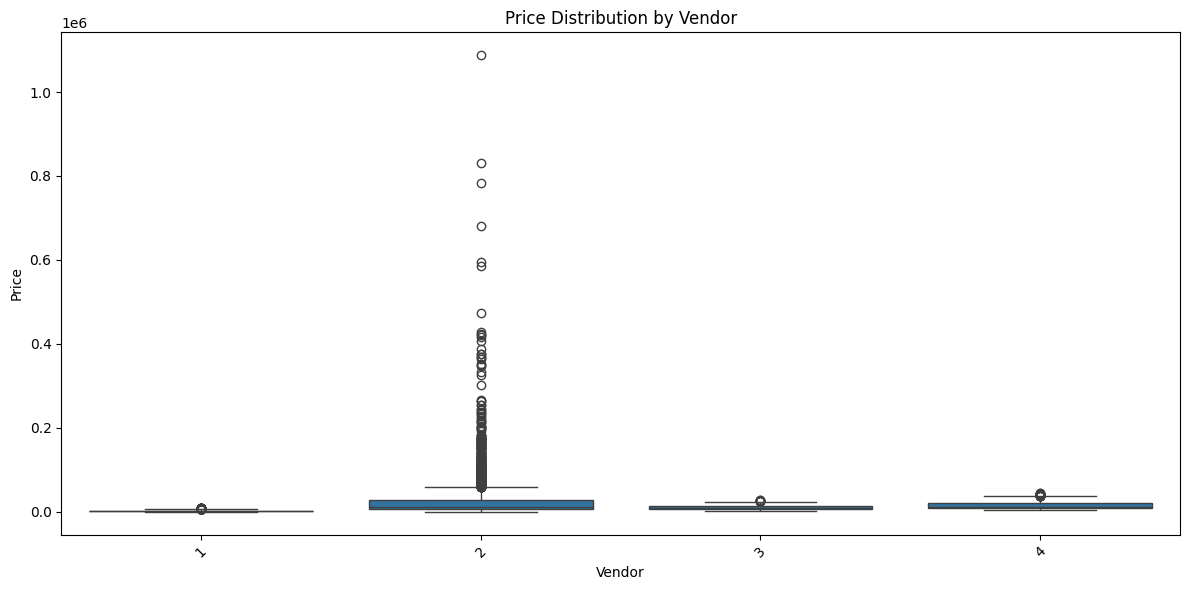

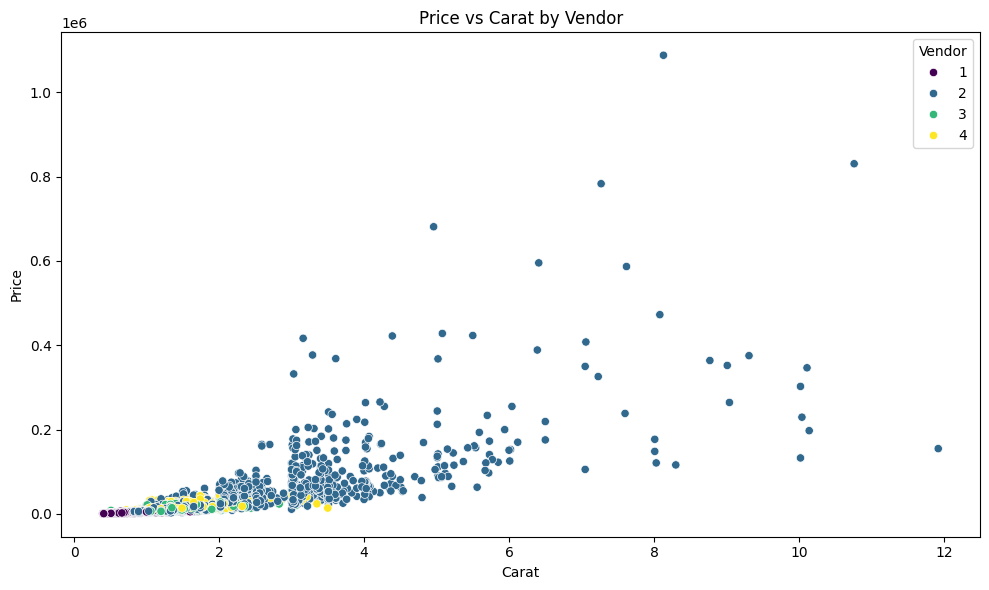

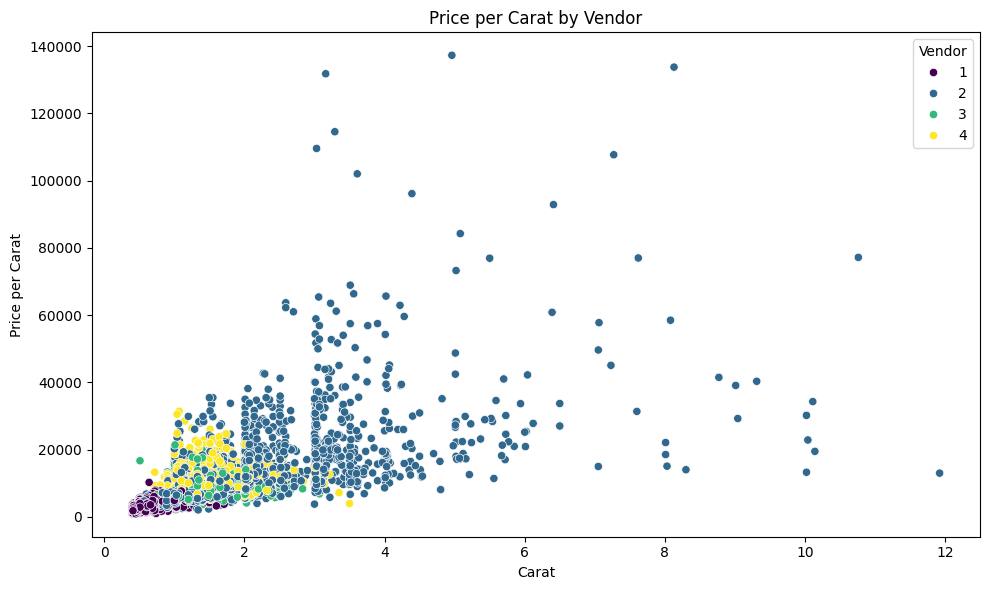

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the data is available as a DataFrame named df
# Example code to generate the requested plots based on the user's data structure

# Load the data (here, we'll simulate some random data as an example)
# df = pd.read_csv("path_to_data.csv")

# Plot 1: Price Comparison by Vendor (Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Vendor', y='Price', data=data)
plt.title('Price Distribution by Vendor')
plt.xticks(rotation=45)
plt.xlabel('Vendor')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Plot 2: Price vs Carat (Scatter plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Carats', y='Price', hue='Vendor', data=data, palette='viridis')
plt.title('Price vs Carat by Vendor')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Plot 3: Price per Carat by Vendor (Scatter plot)
data['Price_per_Carat'] = data['Price'] / data['Carats']
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Carats', y='Price_per_Carat', hue='Vendor', data=data, palette='viridis')
plt.title('Price per Carat by Vendor')
plt.xlabel('Carat')
plt.ylabel('Price per Carat')
plt.tight_layout()
plt.show()


In [118]:
data.groupby('Vendor').describe()['Retail']

,count,mean,std,min,25%,50%,75%,max
Vendor,,,,,,,,
1,2702.0,3604.009993,2792.686575,45.0,1556.25,2667.5,4650.00,15805.0
2,3241.0,39124.959889,76957.682430,370.0,9665.00,16615.0,40145.00,1675190.0
3,1106.0,15292.400542,8123.491228,340.0,9491.25,13342.5,20076.25,46310.0
4,1001.0,19557.997003,10743.500722,720.0,11795.00,16360.0,25605.00,54730.0


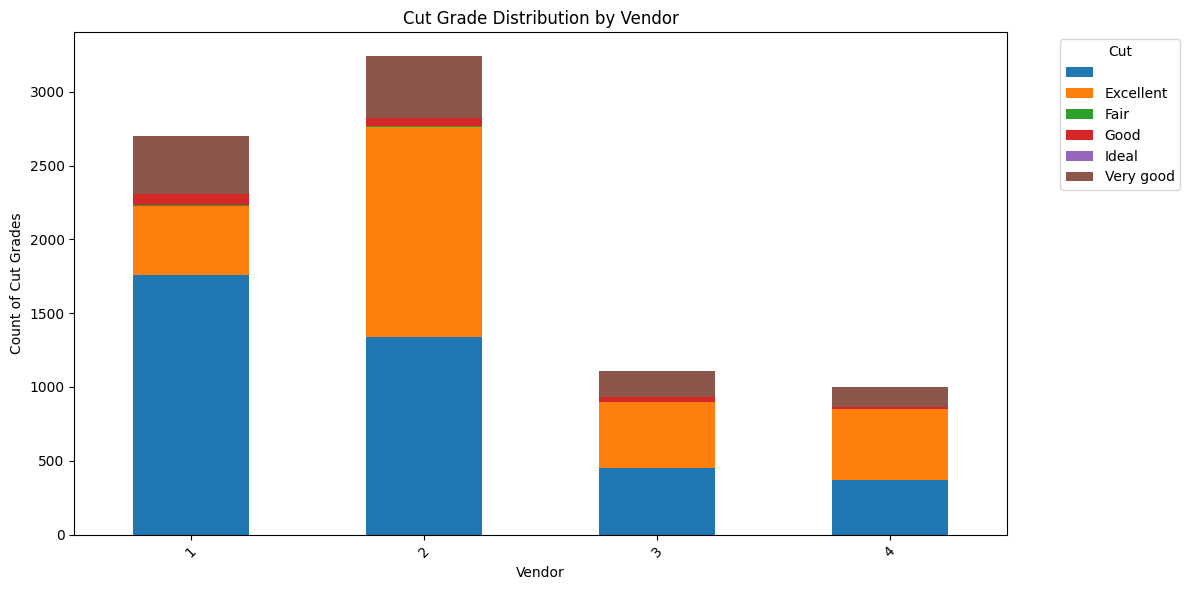

In [147]:
# Count occurrences of clarity grades per vendor
clarity_counts = data.groupby('Vendor')['Cut'].value_counts().unstack().fillna(0)

# Create a bar chart
clarity_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize the plot
plt.title('Cut Grade Distribution by Vendor')
plt.xlabel('Vendor')
plt.ylabel('Count of Cut Grades')
plt.xticks(rotation=45)
plt.legend(title='Cut', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


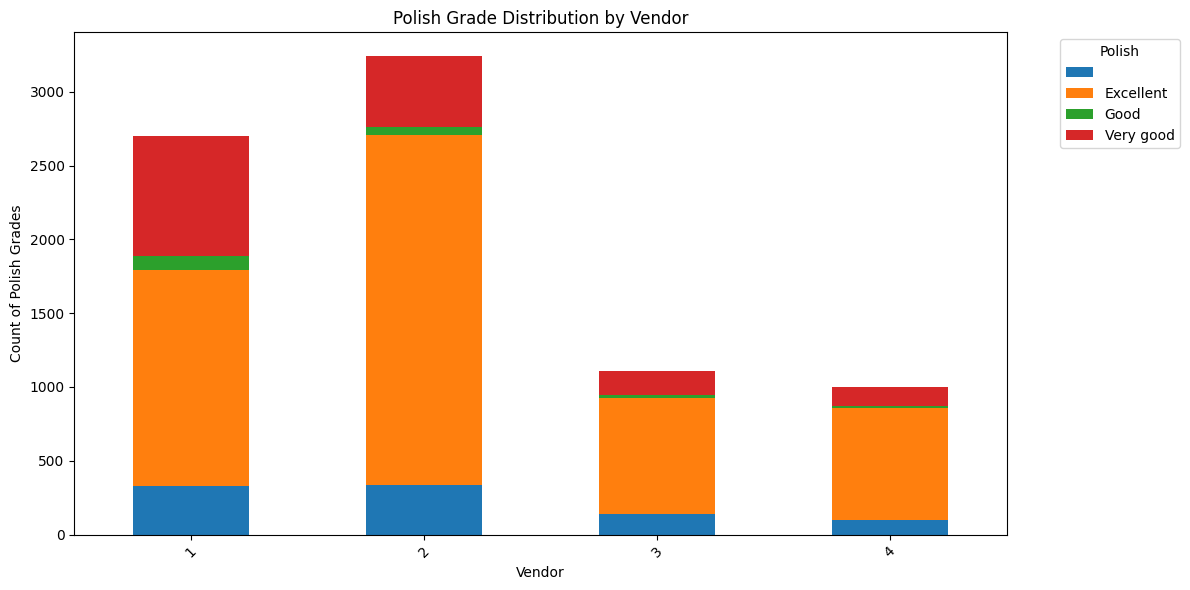

In [145]:
# Count occurrences of clarity grades per vendor
clarity_counts = data.groupby('Vendor')['Polish'].value_counts().unstack().fillna(0)

# Create a bar chart
clarity_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize the plot
plt.title('Polish Grade Distribution by Vendor')
plt.xlabel('Vendor')
plt.ylabel('Count of Polish Grades')
plt.xticks(rotation=45)
plt.legend(title='Polish', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Cleaning the Offers df

In [16]:
offers_df = pd.read_csv('offers.csv')


In [17]:
offers_df.shape

(2683, 16)

In [18]:
offers_df[['length', 'width', 'depth']] = offers_df['Measurements'].str.extract(
    r'(\d+\.\d+)[x*](\d+\.\d+)[x*](\d+\.\d+)'
)
offers_df[['length', 'width', 'depth']] = offers_df[['length', 'width', 'depth']].apply(pd.to_numeric)

offers_df['volume_mm3'] = offers_df['length'] * offers_df['width'] * offers_df['depth']

print(offers_df[['Measurements', 'volume_mm3']].head())
offers_df = offers_df.drop(columns=['Measurements'])


     Measurements  volume_mm3
0  4.81x4.78x3.01   69.205318
1  4.64x4.61x2.95   63.101680
2  4.76x4.74x2.95   66.559080
3  4.63x4.59x2.96   62.905032
4  4.67x4.62x2.99   64.510446


In [19]:
offers_df.isnull().sum()

,0
id,0
Carats,0
Cert,213
Clarity,0
Color,0
Cut,0
Depth,497
Known_Conflict_Diamond,2378
Polish,0
Regions,0


In [20]:
offers_df = offers_df.drop('Offers', axis=1)

# Numeric Imputing
numeric_df_2 = offers_df.select_dtypes(include=['float', 'int64'])
non_numeric_df_2 = offers_df.select_dtypes(exclude='number')

numeric_df_2 = numeric_df_2.apply(pd.to_numeric, errors='coerce')

# KNN to get the most accurate imputed values
knn_imputer = KNNImputer(n_neighbors=3)
imputed_numeric_array_2 = knn_imputer.fit_transform(numeric_df_2)
imputed_numeric_df_2 = pd.DataFrame(imputed_numeric_array_2, columns=numeric_df_2.columns)
imputed_df_2 = pd.concat([imputed_numeric_df_2, non_numeric_df_2], axis=1)

# Fill missing values for categorical columns
imputed_df_2['Cert'] = imputed_df_2['Cert'].fillna('Missing')
imputed_df_2['Clarity'] = imputed_df_2['Clarity'].fillna(imputed_df_2['Clarity'].mode()[0])

# One hot encoding categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Set sparse_output=False
encoded_data_2 = encoder.fit_transform(imputed_df_2[non_numeric_df_2.columns.tolist()])
print("Encoded data shape:", encoded_data_2.shape)

# Check if any columns have only one unique category and handle them
for col in non_numeric_df.columns:
    if imputed_df_2[col].nunique() == 1:
        print(f"Column '{col}' has only one unique value. Skipping one-hot encoding.")

# Convert encoded data into a DataFrame with the correct column names
encoded_column_names_2 = encoder.get_feature_names_out(input_features=non_numeric_df_2.columns.tolist())
encoded_df_2 = pd.DataFrame(encoded_data_2, columns=encoded_column_names_2)
print(encoded_df_2.shape)

Encoded data shape: (2683, 70)
(2683, 70)


In [21]:
# Concatenate the encoded categorical columns with the numeric columns
final_offers = pd.concat([imputed_numeric_df_2, encoded_df_2], axis=1)

print(final_offers.dtypes)
print(final_offers.head())

id                    float64
Carats                float64
Depth                 float64
Table                 float64
Vendor                float64
                       ...   
Symmetry_Excellent    float64
Symmetry_Faint        float64
Symmetry_Fair         float64
Symmetry_Good         float64
Symmetry_Very good    float64
Length: 79, dtype: object
       id  Carats  Depth      Table  Vendor  length  width  depth  volume_mm3  \
0  8051.0    0.42   62.7  57.000000     1.0    4.81   4.78   3.01   69.205318   
1  8052.0    0.40   63.8  59.000000     1.0    4.64   4.61   2.95   63.101680   
2  8053.0    0.41   62.2  58.000000     1.0    4.76   4.74   2.95   66.559080   
3  8054.0    0.40   64.2  58.000000     1.0    4.63   4.59   2.96   62.905032   
4  8055.0    0.40   64.3  57.666667     1.0    4.67   4.62   2.99   64.510446   

   Cert_AGSL  ...  Shape_ROUND  Shape_Radiant  Shape_Round  Shape_Uncut  \
0        1.0  ...          0.0            0.0          1.0          0.0   
1      

In [22]:
final_offers.shape

(2683, 79)

In [29]:
# Get the column names for both datasets
final_offers_columns = set(final_offers.columns)
final_df_columns = set(final_df.columns)

# Find columns that are in final_offers but not in X_train_2
missing_in_train = final_offers_columns - final_df_columns

# Find columns that are in X_train_2 but not in final_offers
missing_in_final_offers = final_df_columns - final_offers_columns

# Add the missing columns to X_train_2 and fill with 0
for col in missing_in_train:
    final_df[col] = 0

# Add the missing columns to final_offers and fill with 0
for col in missing_in_final_offers:
    final_offers[col] = 0


In [30]:
## Get the column names for both datasets
final_offers_columns = set(final_offers.columns)
final_df_columns = set(final_df.columns)

# Find columns that are in final_offers but not in X_train_2
missing_in_train = final_offers_columns - final_df_columns

# Find columns that are in X_train_2 but not in final_offers
print("Columns in final_offers but not in X_train:", missing_in_train)

print("Columns in X_train but not in final_offers:", missing_in_final_offers)

Columns in final_offers but not in X_train: set()
Columns in X_train but not in final_offers: set()


# Part 2: Creating the Models

## Feature Selection: Retail Price Predicting Model

**Goal:** Build a feature selection model to find the best way to predict Price

**Strategy**: Test out some different types of regression models, something like an XGBoost could be good.

*Note:* I should be building a model that determines retail price.

In [34]:
random_grid = {'max_depth': [2, 7, 12],
        'learning_rate': [0.01],
        'reg_lambda':[1],
        'n_estimators':[100, 1000, 5000],
        'gamma': [0],
        'subsample': [0.5]}

model = XGBRegressor(random_state=1, tree_method='hist')


In [35]:
y = final_df['Retail']
X = final_df.drop(['Retail', 'Price', 'LogPrice', 'LogRetail', 'Profit'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [37]:
# Checking with a randomized grid to see if this model is close to ideal
# Less computationaly expensive way to check if I am in the right ballpark

random_search = RandomizedSearchCV(
    model,
    param_distributions=random_grid,
    cv=KFold(n_splits=3, shuffle=True, random_state=1),
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_iter=100,
    random_state=1,
    n_jobs=-1,
)
random_search.fit(X_train, y_train)
print(f"Error from randomized model: {mean_absolute_error(y_test, random_search.best_estimator_.predict(X_test))}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Error from randomized model: 4534.938664179263


In [40]:
print(f"Params from randomized model: {random_search.best_params_}")

Params from randomized model: {'subsample': 0.5, 'reg_lambda': 1, 'n_estimators': 5000, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0}


This model was found after a few larger grids were run, this final grid gave me a stronger MAE than any other type of model.

In [41]:
grid = {'max_depth': [7, 9],
        'learning_rate': [0.01],
        'reg_lambda':[1],
        'n_estimators':[5000],
        'gamma': [0],
        'subsample': [0.1, 0.5]}

In [42]:
st = time.time()

cv_settings = KFold(n_splits=4, shuffle=True, random_state=1)

gscv = GridSearchCV(model, grid, cv=cv_settings, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
gscv.fit(X_train, y_train)

print(gscv.best_params_)
print(gscv.best_score_)

print('Execution time:', (time.time() - st)/60, 'minutes')

Fitting 4 folds for each of 4 candidates, totalling 16 fits
{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 5000, 'reg_lambda': 1, 'subsample': 0.5}
-4038.0134830013567
Execution time: 5.766624625523885 minutes


In [43]:
print(f"Error from ideal model: {mean_absolute_error(y_test, gscv.predict(X_test))}")

Error from ideal model: 4534.938664179263


In [50]:
# Seeing which features are most crucial in this model
pd.concat([pd.Series(gscv.best_estimator_.feature_importances_),
           pd.Series(X_train.columns)],axis=1).sort_values(by = 0,ascending = False).head(10)


,0,1
16,0.142924,Clarity_IF
6,0.116210,width
24,0.074043,Color_D
8,0.070435,volume_mm3
5,0.035303,length
23,0.034875,Clarity_VVS2
7,0.031670,depth
62,0.031019,Known_Conflict_Diamond_False
48,0.029403,Color_M
1,0.027306,Carats


## Feature Selection: Price Predicting Model

In [53]:
y_2 = final_df['Price']
X_2 = final_df.drop(['Retail', 'Price', 'LogPrice', 'LogRetail', 'Profit'], axis=1)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,y_2,test_size=0.2,random_state=1)

In [54]:
random_search_price = RandomizedSearchCV(
    model,
    param_distributions=random_grid,
    cv=KFold(n_splits=3, shuffle=True, random_state=1)
,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_iter=100,
    random_state=1,
    n_jobs=-1,
)
random_search_price.fit(X_train_2, y_train_2)
print(f"Error from randomized model: {mean_absolute_error(y_test_2, random_search_price.best_estimator_.predict(X_test_2))}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Error from randomized model: 2623.4516893345376


In [55]:
random_search_price.best_params_

{'subsample': 0.5,
 'reg_lambda': 1,
 'n_estimators': 5000,
 'max_depth': 7,
 'learning_rate': 0.01,
 'gamma': 0}

In [56]:
st = time.time()

price_model = XGBRegressor(random_state=1, tree_method='hist')

grid = {'max_depth': [6, 8],
        'learning_rate': [0.01, 0.1],
        'reg_lambda':[1],
        'n_estimators':[5000],
        'gamma': [0],
        'subsample': [0.5]}

cv_settings = KFold(n_splits=4, shuffle=True, random_state=1)

gscv_2 = GridSearchCV(price_model, grid, cv=cv_settings, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
gscv_2.fit(X_train_2, y_train_2)

print(gscv_2.best_params_)
print(gscv_2.best_score_)

print('Execution time:', (time.time() - st)/60, 'minutes')
print(f"Error from ideal model: {mean_absolute_error(y_test_2, gscv_2.predict(X_test_2))}")

Fitting 4 folds for each of 4 candidates, totalling 16 fits
{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 5000, 'reg_lambda': 1, 'subsample': 0.5}
-2326.7968939325083
Execution time: 5.67142745256424 minutes
Error from ideal model: 2637.2876479060014


# Part 3: Defining the Function

## Making function

In [68]:
predicted_retail_model = gscv
predicted_price_model = gscv_2
budget = 5000000

In [75]:
def maximize_total_profit(data, predicted_retail_model, predicted_price_model, budget=5000000, feature_columns=None):
    """
    I have to pick the diamonds to maximize total profit under a budget constraint.

    Parameters:
        data (DataFrame): The offers dataset.
        predicted_retail_model: gcsv model to predict retail prices.
        predicted_price_model: gcsv_2 model to predict acquisition prices.
        budget: 5 million dollar budget.
        feature_columns: list of feature columns used for model training (if available).

    Returns:
        DataFrame: Updated dataset with offer decisions and amounts.
    """
    # Create a copy of the input data to avoid modifying the original DataFrame
    data_copy = data.copy()

    # Select only the features used for training to make predictions
    prediction_data = data_copy[feature_columns]

    # Step 1: Predict retail and acquisition prices using the trained models
    data_copy['Predicted_Retail'] = predicted_retail_model.predict(prediction_data)
    data_copy['Predicted_Price'] = predicted_price_model.predict(prediction_data)

    # Step 2: Calculate expected profit
    data_copy['Expected_Profit'] = data_copy['Predicted_Retail'] - data_copy['Predicted_Price']

    # Step 3: Calculate profit-to-price ratio
    data_copy['Profit_Ratio'] = data_copy['Expected_Profit'] / data_copy['Predicted_Price']


    # Step 4: Sort by profit-to-price ratio in descending order
    sorted_data = data_copy[data_copy['Expected_Profit'] > 0].copy().sort_values(by='Profit_Ratio', ascending=False).reset_index(drop=True)

    total_spent = 0
    offers = []

    # Loop through diamonds and select based on budget
    for _, diamond in sorted_data.iterrows():
        predicted_price = diamond['Predicted_Price']

        # Skip negative offers
        if predicted_price < 0:
            offers.append(None)  # No offer due to negative price
            continue

        # Check if adding this diamond's price exceeds the budget
        if total_spent + predicted_price <= budget:
            offers.append(predicted_price)  # Add offer price
            total_spent += predicted_price
        else:
            offers.append(None)  # No offer (null value for no offer)

    # Step 6: Add 'Offers' column and restore original df order
    sorted_data['Offers'] = offers

    # Step 7: Ensure the 'Offers' column has None for no offer made (but 'id' remains unchanged)
    sorted_data['Offers'] = sorted_data['Offers'].where(sorted_data['Offers'].notnull(), None)

    # Step 8: Ensure the total spent doesn't exceed the budget
    total_offers_sum = sorted_data['Offers'].apply(lambda x: 0 if x is None else x).sum()
    if total_offers_sum > budget:
        print(f"Warning: The total sum of offers exceeds the budget of $5,000,000!")

    # Step 9: Return the dataset with 'id' and 'Offers', ensuring 'id' is not missing
    # Ensure that we don't drop or change the 'id' column
    return sorted_data[['id', 'Expected_Profit', 'Offers']]


## Applying the Function

In [76]:
# Step 1: Apply maximize_total_profit function
selected_diamonds_greedy = maximize_total_profit(final_offers, predicted_retail_model, predicted_price_model, feature_columns=X_train.columns)

selected_diamonds = selected_diamonds_greedy[selected_diamonds_greedy['Offers'] != 'NA']

# Step 2: Calculate the total profit and total spent from the updated dataset
# Use 'Offer' column for total spent, not 'Predicted_Price'
total_profit_greedy = selected_diamonds[selected_diamonds['Expected_Profit'] != 'NA']['Expected_Profit'].sum()
total_spent_greedy = selected_diamonds['Offers'].apply(lambda x: 0 if x == 'NA' else x).sum()

# Step 3: Print the results
print("Total Profit (Greedy):", total_profit_greedy)
print("Total Spent (Greedy):", total_spent_greedy)

Total Profit (Greedy): 4468941.0
Total Spent (Greedy): 4999533.735748291


In [72]:
total_spent_greedy < 5000000

True

# Part 4: Final Output

## Applying the function

## Final Output

In [81]:
def fill_offers_in_original_data(original_data, selected_offers):
    """
    Fill the 'offers' column in the original dataset with the selected offers,
    leaving null values for diamonds not selected.

    Parameters:
        original_data (DataFrame): The original dataset with all diamonds.
        selected_offers (DataFrame): The dataset with selected diamonds and offers.

    Returns:
        DataFrame: Updated original dataset with the 'offers' column filled.
    """
    # Ensure both 'id' columns are integers for consistency
    original_data['id'] = original_data['id'].astype(int)
    selected_offers['id'] = selected_offers['id'].astype(int)

    # Create a dictionary mapping id to offers
    offers_dict = selected_offers.set_index('id')['Offers'].to_dict()

    # Populate the 'offers' column in the original dataset
    original_data['offers'] = original_data['id'].map(offers_dict)

    return original_data


In [84]:
# Fill the offers column in the original dataset
updated_dataset = fill_offers_in_original_data(offers_df, selected_diamonds_greedy)


,0
id,0
Carats,0
Cert,213
Clarity,0
Color,0
Cut,0
Depth,497
Known_Conflict_Diamond,2378
Polish,0
Regions,0


In [85]:
# Export the result as a CSV
updated_dataset.to_csv('data_with_offers.csv', index=False)

print("CSV file has been created.")


CSV file has been created.
